In [1]:
import warnings
# hide powerlaw's 'invalid value encountered in true divide' warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import powerlaw
import pylandstats as pls
import seaborn as sns
import swisslandstats as sls

from swiss_urbanization.data import settings

In [2]:
# set 'paper' seaborn style
sns.set('paper')

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']

# keyword arguments to be passed to `savefig`
savefig_kws = {
    'dpi': 300,
    'bbox_inches': 'tight',
    'pad_inches': 0
}

In [3]:
urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

In [4]:
agglomeration_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res, nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalAnalysis(
        landscapes, dates=dates)

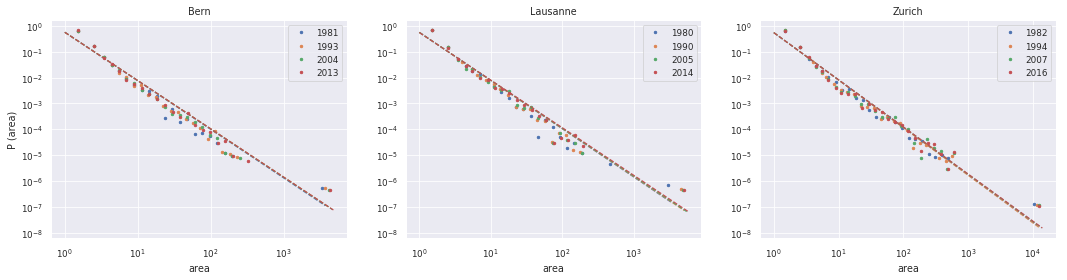

In [5]:
num_cities = len(agglomeration_slugs)
current_palette = sns.color_palette()
fig = plt.figure(figsize=(num_cities * figwidth, figheight))
ax = None  # to pass as `sharey` argument in the first iteration

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    # print(agglomeration_slug.capitalize())
    sta = agglomeration_dict[agglomeration_slug]
    ax = fig.add_subplot(1, num_cities, i, sharey=ax)
    for k, (date, landscape) in enumerate(zip(sta.dates, sta.landscapes)):
        area_ser = landscape.area(urban_class)
       
        ax.set_title(agglomeration_slug.capitalize())
        color = current_palette[k]

        powerlaw.plot_pdf(area_ser, ax=ax, color=color,
                          linestyle='None', marker='.', label=date)
        # `xmin=1` because patches cannot have 0 area
        # `discrete=True` because patches are groups of pixels
        fit = powerlaw.Fit(
            area_ser.values, xmin=1, discrete=True, verbose=False)        
        fit.power_law.plot_pdf(ax=ax, color=color, linestyle='--')

    ax.legend()
    ax.set_xlabel('area')

fig.axes[0].set_ylabel('P (area)')
fig.savefig('../reports/figures/size_frequency_distribution.pdf', **savefig_kws)